# Survival Models with HMM Features

In [1]:
import pandas as pd
import numpy as np
import yaml
from importlib import resources as impresources
from recurrent_health_events_prediction import configs
from recurrent_health_events_prediction.training.utils import summarize_search_results, save_coef_lifelines_plot

import os

with open((impresources.files(configs) / 'model_config.yaml')) as f:
    model_config = yaml.safe_load(f)
with open((impresources.files(configs) / 'data_config.yaml')) as f:
    data_config = yaml.safe_load(f)

training_data_config = data_config["training_data"]["mimic"]
training_data_path = training_data_config["preprocessed_path"]

## Import Data

### HMM that Generated the Features

In [2]:
from recurrent_health_events_prediction.model.RecurrentHealthEventsHMM import RecurrentHealthEventsHMM
from recurrent_health_events_prediction.model.utils import load_model

hmm_model_name = "hmm_multiple_emissions_time_cat"
base_model_path = "/workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm"
hmm_features_dir = os.path.join(base_model_path, hmm_model_name)
model_pickle_path = os.path.join(hmm_features_dir, hmm_model_name + ".pkl")
hmm_feature_extractor_model: RecurrentHealthEventsHMM = load_model(model_pickle_path)
hmm_config = hmm_feature_extractor_model.config
print("HMM Model Config:")
for key, value in hmm_config.items():
    print(f"{key}: {value}")

HMM Model Config:
add_distribution_params: {'READMISSION_TIME_CAT': {'bins': [0, 30, 120], 'labels': ['0-30', '30-120', '120+'], 'n_categories': 3}}
feature_define_state_labels: READMISSION_TIME_CAT
features: {'CHARLSON_INDEX': 'poisson', 'LOG_DAYS_IN_ICU': 'gaussian', 'READMISSION_TIME_CAT': 'categorical'}
hidden_state_labels: ['high', 'medium', 'low']
id_col: SUBJECT_ID
model_name: hmm_multiple_emissions_time_cat
n_states: 3
save_model_path: /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm
time_col: ADMITTIME


### Read Data

In [3]:
filepath = os.path.join(hmm_features_dir, "last_events_with_hidden_states_mult_hosp_only.csv")
last_events_hmm_features_df = pd.read_csv(filepath, index_col=0)

In [4]:
last_events_hmm_features_df.columns

Index(['HADM_ID', 'ADMITTIME', 'DISCHTIME', 'ADMISSION_TYPE', 'ETHNICITY',
       'INSURANCE', 'HOSPITALIZATION_DAYS', 'NUM_COMORBIDITIES',
       'TYPES_COMORBIDITIES', 'HAS_DIABETES', 'HAS_COPD', 'HAS_CONGESTIVE_HF',
       'NEXT_ADMISSION_TYPE', 'NUM_PREV_HOSPITALIZATIONS', 'PREV_DISCHTIME',
       'NEXT_ADMITTIME', 'DAYS_SINCE_LAST_HOSPITALIZATION',
       'DAYS_UNTIL_NEXT_HOSPITALIZATION', 'PREV_READMISSION_30_DAYS',
       'READMISSION_30_DAYS', 'READMISSION_TIME_CAT',
       'READMISSION_TIME_CAT_ENCODED', 'READM_30_DAYS_PAST_MEAN',
       'READM_30_DAYS_PAST_SUM', 'DAYS_UNTIL_NEXT_HOSP_PAST_MEAN',
       'DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN', 'DAYS_UNTIL_NEXT_HOSP_PAST_STD',
       'TOTAL_HOSPITALIZATIONS', 'DAYS_IN_ICU', 'NUM_DRUGS', 'NUM_PROCEDURES',
       'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'AGE', 'CHARLSON_INDEX',
       'FIRST_ADMITTIME', 'LAST_DISCHTIME', 'PARTICIPATION_DAYS',
       'TOTAL_PARTICIPATION_DAYS', 'READMISSION_EVENT', 'EVENT_DURATION',
       'IN_HOSP_DEATH_EV

In [5]:
last_events_hmm_features_df.head(10)

,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ETHNICITY,INSURANCE,HOSPITALIZATION_DAYS,NUM_COMORBIDITIES,TYPES_COMORBIDITIES,HAS_DIABETES,...,LOG_DAYS_SINCE_LAST_HOSPITALIZATION,LOG_NUM_PREV_HOSPITALIZATIONS,LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEAN,LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN,IS_LAST_EVENT,IS_HISTORICAL_EVENT,HEALTH_HIDDEN_RISK,PROB_HIDDEN_RISK_HIGH,PROB_HIDDEN_RISK_MEDIUM,PROB_HIDDEN_RISK_LOW
SUBJECT_ID,,,,,,,,,,,,,,,,,,,,,
107,182383,2121-11-30 19:24:00,2121-12-05 14:18:00,EMERGENCY,HISPANIC OR LATINO,Medicare,4.787500,4,"['renal_disease', 'congestive_heart_failure', ...",False,...,7.814044,0.693147,7.814044,7.814044,1,0,low,0.102482,0.438094,0.459423
109,155726,2142-08-13 04:03:00,2142-08-16 18:17:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Medicaid,3.593056,6,"['peripheral_vascular_disease', 'peptic_ulcer_...",False,...,3.062937,3.496508,3.894755,2.698958,1,0,medium,0.108213,0.482084,0.409702
236,182562,2135-05-26 11:28:00,2135-05-28 16:46:00,EMERGENCY,PATIENT DECLINED TO ANSWER,Private,2.220833,2,"['mild_liver_disease', 'other']",False,...,5.410802,0.693147,5.410802,5.410802,1,0,high,0.431384,0.166290,0.402326
249,149546,2155-02-03 20:16:00,2155-02-14 11:15:00,EMERGENCY,WHITE,Medicare,10.624306,8,"['chronic_pulmonary_disease', 'cerebrovascular...",True,...,7.528989,0.693147,7.528989,7.528989,1,0,medium,0.000000,0.794176,0.200538
256,188869,2170-06-15 03:06:00,2170-06-27 16:17:00,EMERGENCY,WHITE,Medicare,12.549306,4,"['chronic_pulmonary_disease', 'peripheral_vasc...",False,...,7.257424,1.098612,7.132493,7.132493,1,0,medium,0.246323,0.550406,0.203271
291,125726,2106-04-17 12:24:00,2106-04-19 15:10:00,EMERGENCY,WHITE,Medicare,2.115278,4,"['peptic_ulcer_disease', 'other', 'rheumatic_d...",False,...,7.290958,0.693147,7.290958,7.290958,1,0,low,0.102482,0.438094,0.459423
305,122211,2127-06-19 23:49:00,2127-07-16 13:58:00,EMERGENCY,WHITE,Medicare,26.589583,3,"['congestive_heart_failure', 'diabetes_with_cc...",True,...,6.266276,1.098612,5.952636,5.952636,1,0,medium,0.341688,0.455745,0.202566
323,128132,2119-09-21 20:34:00,2119-10-06 18:50:00,EMERGENCY,WHITE,Medicare,14.927778,4,"['congestive_heart_failure', 'diabetes_with_cc...",True,...,7.114192,1.098612,6.667396,6.667396,1,0,high,0.468114,0.343698,0.188188
339,107660,2188-04-01 07:11:00,2188-04-18 15:25:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Medicaid,17.343056,1,['other'],False,...,5.445168,1.098612,4.946568,4.946568,1,0,high,0.496113,0.161285,0.342601


## Survival Models

In [7]:
next_event_model_config = model_config["mimic"]["next_event_model"]

In [8]:
columns_to_select = ['EVENT_DURATION', 'READMISSION_TIME_CAT', 'HEALTH_HIDDEN_RISK'] + [col for col in last_events_hmm_features_df.columns if col.startswith('PROB_HIDDEN_RISK')]
last_events_hmm_features_df[columns_to_select]

,EVENT_DURATION,READMISSION_TIME_CAT,HEALTH_HIDDEN_RISK,PROB_HIDDEN_RISK_HIGH,PROB_HIDDEN_RISK_MEDIUM,PROB_HIDDEN_RISK_LOW
SUBJECT_ID,,,,,,
107,120.000000,120+,low,0.102482,0.438094,0.459423
109,12.063194,0-30,medium,0.108213,0.482084,0.409702
236,120.000000,120+,high,0.431384,0.166290,0.402326
249,120.000000,120+,medium,0.000000,0.794176,0.200538
256,49.901389,30-120,medium,0.246323,0.550406,0.203271
...,...,...,...,...,...,...
99469,120.000000,120+,medium,0.063105,0.509223,0.427671
99503,120.000000,120+,low,0.132590,0.395763,0.471647
99556,120.000000,120+,medium,0.014041,0.720395,0.265564


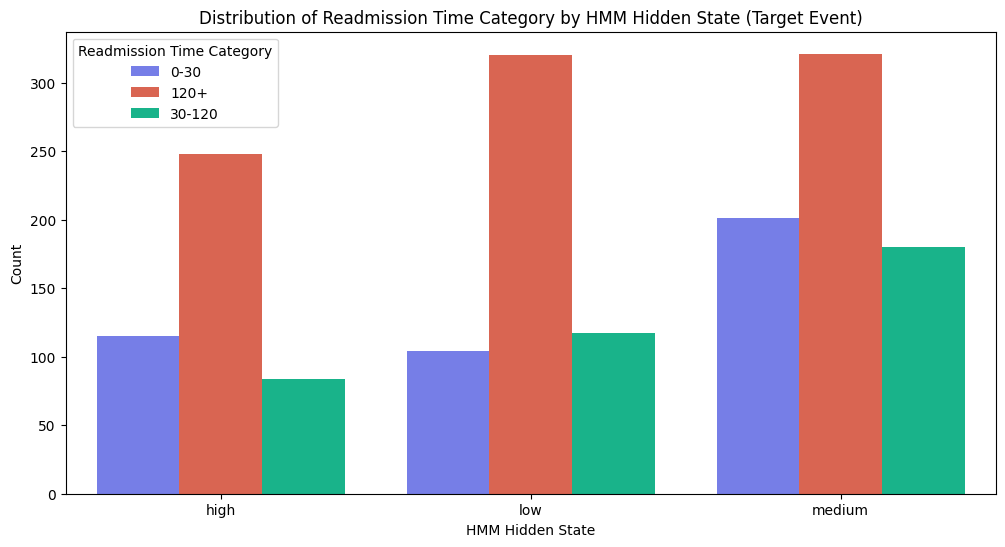

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

hidden_states = last_events_hmm_features_df["HEALTH_HIDDEN_RISK"].unique()
labels = hidden_states.tolist()
label_score = {
    'high': 4,
 #   'high_1': 3,
    'medium': 2,
 #   'low_2': 1,
    'low': 0
}
labels = sorted(labels, key=lambda label: label_score[label], reverse=True)

from recurrent_health_events_prediction.training.utils import plot_cat_readmission_time_by_hidden_state
plot_cat_readmission_time_by_hidden_state(last_events_hmm_features_df, title_suffix=" (Target Event)")

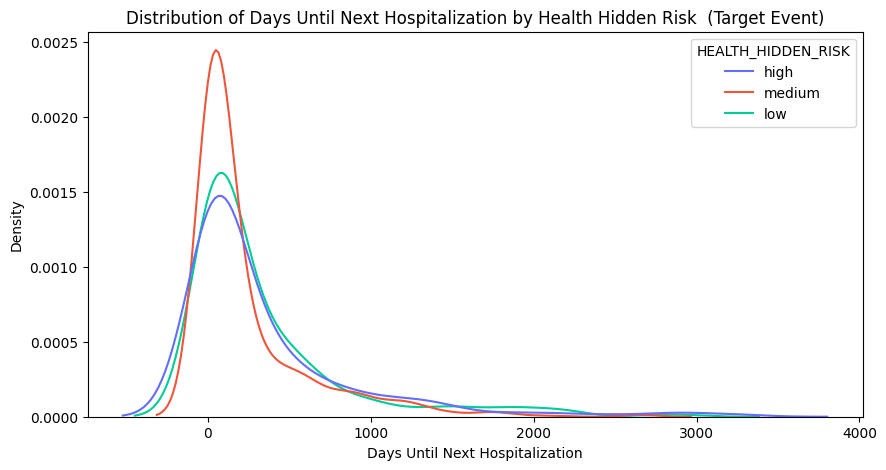

In [11]:
from recurrent_health_events_prediction.training.utils import plot_feature_kde_by_hidden_state
plot_feature_kde_by_hidden_state('DAYS_UNTIL_NEXT_HOSPITALIZATION', last_events_hmm_features_df, hue_order=labels, suffix_title=" (Target Event)")

### Train Test Split - Scaling

In [12]:
hmm_features = [col for col in last_events_hmm_features_df.columns if col.startswith('PROB_HIDDEN_RISK')]

In [13]:
last_events_hmm_features_df["RANDOM_FEATURE"] = np.random.rand(len(last_events_hmm_features_df))

In [14]:
from sklearn.discriminant_analysis import StandardScaler
from recurrent_health_events_prediction.training.utils import train_test_split_survival_data

X_train, X_test = train_test_split_survival_data(last_events_hmm_features_df, duration_col="EVENT_DURATION", event_col="READMISSION_EVENT", q_bins=1)

features_to_scale = ["NUM_PREV_HOSPITALIZATIONS", "LOG_NUM_PREV_HOSPITALIZATIONS", "LOG_HOSPITALIZATION_DAYS",
                     "LOG_DAYS_IN_ICU", "AGE", "CHARLSON_INDEX", "LOG_DAYS_SINCE_LAST_HOSPITALIZATION",
                     'READM_30_DAYS_PAST_MEAN', 'READM_30_DAYS_PAST_SUM',
                     "NUM_COMORBIDITIES", "NUM_PROCEDURES", "NUM_DRUGS", "RANDOM_FEATURE"] + hmm_features

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

scaler = StandardScaler()

X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

Train set event composition:
 READMISSION_EVENT
0    0.525148
1    0.474852
Name: count, dtype: float64
Test set event composition:
 READMISSION_EVENT
0    0.529586
1    0.470414
Name: count, dtype: float64
Train average event duration: 80.71805966469428
Test average event duration: 82.42304610453648


In [15]:
from lifelines import CoxPHFitter
features = ["LOG_NUM_PREV_HOSPITALIZATIONS", "LOG_HOSPITALIZATION_DAYS", "LOG_DAYS_IN_ICU", "NUM_COMORBIDITIES",
            "NUM_PROCEDURES", "NUM_DRUGS", "AGE", "CHARLSON_INDEX", 'HAS_COPD', 'HAS_DIABETES', 'HAS_CONGESTIVE_HF',
            'LOG_DAYS_SINCE_LAST_HOSPITALIZATION', 'PREV_READMISSION_30_DAYS', 
            'READM_30_DAYS_PAST_MEAN', 'READM_30_DAYS_PAST_SUM',
            'HAS_DIABETES', 'HAS_COPD', "RANDOM_FEATURE"] + hmm_features

significant_features = []
for col in features:
    cph = CoxPHFitter()
    cph.fit(X_train_scaled[[col, 'EVENT_DURATION', 'READMISSION_EVENT']], 'EVENT_DURATION', event_col='READMISSION_EVENT')
    summary = cph.summary
    p_value = summary.loc[col, 'p']
    if p_value < 0.05:
        significant_features.append(col)
    print(f"{col}: HR={summary.loc[col, 'exp(coef)']:.2f}, p={p_value:.3g}")

LOG_NUM_PREV_HOSPITALIZATIONS: HR=1.20, p=1.28e-07
LOG_HOSPITALIZATION_DAYS: HR=1.11, p=0.00684
LOG_DAYS_IN_ICU: HR=1.22, p=8.66e-08
NUM_COMORBIDITIES: HR=1.26, p=2.24e-09
NUM_PROCEDURES: HR=1.03, p=0.394
NUM_DRUGS: HR=1.08, p=0.0629
AGE: HR=1.11, p=0.0101
CHARLSON_INDEX: HR=1.31, p=2.52e-12
HAS_COPD: HR=1.17, p=0.0462
HAS_DIABETES: HR=1.25, p=0.0052
HAS_CONGESTIVE_HF: HR=1.39, p=7.34e-05
LOG_DAYS_SINCE_LAST_HOSPITALIZATION: HR=0.74, p=4.45e-14
PREV_READMISSION_30_DAYS: HR=1.79, p=3.29e-12
READM_30_DAYS_PAST_MEAN: HR=1.30, p=3.18e-13
READM_30_DAYS_PAST_SUM: HR=1.12, p=1e-09
HAS_DIABETES: HR=1.25, p=0.0052
HAS_COPD: HR=1.17, p=0.0462
RANDOM_FEATURE: HR=0.96, p=0.324
PROB_HIDDEN_RISK_HIGH: HR=0.91, p=0.0343
PROB_HIDDEN_RISK_MEDIUM: HR=1.24, p=6.7e-08
PROB_HIDDEN_RISK_LOW: HR=0.84, p=4.37e-06


### Fit Model with HMM Features

In [16]:
evaluation_times = [15, 30, 60, 90, 100]

In [17]:
final_features = ['AGE', 'CHARLSON_INDEX', 'LOG_NUM_PREV_HOSPITALIZATIONS', 'LOG_DAYS_IN_ICU', 'NUM_DRUGS', 'HAS_DIABETES', 'HAS_COPD']

In [18]:
hmm_features

['PROB_HIDDEN_RISK_HIGH', 'PROB_HIDDEN_RISK_MEDIUM', 'PROB_HIDDEN_RISK_LOW']

In [ ]:
final_features = final_features + ['PROB_HIDDEN_RISK_MEDIUM', 'PROB_HIDDEN_RISK_LOW']

In [20]:
from recurrent_health_events_prediction.training.utils import build_strata_col

strata_col = build_strata_col(X_train_scaled, duration_col='EVENT_DURATION', event_col='READMISSION_EVENT', q_bins=1)

In [21]:
param_lifelines_grid = {
    "penalizer": np.linspace(0.01, 0.1, 20),
    "l1_ratio": np.linspace(0.01, 1, 20)
}

param_grid_gbm_survival = {
    "learning_rate": np.linspace(0.01, 0.2, 10),
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 4, 5, 6, 7, 8],
}

n_iter = 10
random_state = 42
cv = 5

#### Cox PH - HMM Features as Covariates

In [22]:
# Initialize the model with the configuration
from recurrent_health_events_prediction.model.NextEventPredictionModel import NextEventPredictionModel
from recurrent_health_events_prediction.model.model_types import SurvivalModelType

cph_hmm_features_config = next_event_model_config['hmm_based'].copy()
cph_hmm_features_config['features'] = final_features
cph_hmm_features_config['model_name'] = "Cox Proportional Hazard Model with HMM Features"
cph_hmm_features_config['model_type'] = SurvivalModelType.COX_PH.value
cph_hmm_features_config['cluster_col'] = None  # No clustering for this model
cph_hmm_features_config['strata_col'] = None  # No strata for this model
cph_hmm_features_config['base_hmm_name'] = hmm_model_name

In [23]:
from recurrent_health_events_prediction.training.utils import train_next_event_survival_model_rand_search_cv

random_search_cph_hmm_cov = train_next_event_survival_model_rand_search_cv(
    training_df=X_train_scaled,
    model_config=cph_hmm_features_config,
    strata_col_s=strata_col,
    param_grid=param_lifelines_grid,
    n_iter=n_iter,
    random_state=random_state,
    cv=cv
)

cph_model_hmm_cov = random_search_cph_hmm_cov.best_estimator_
cph_model_hmm_cov

KeyError: "['PROB_HIDDEN_RISK_HIGH_1', 'PROB_HIDDEN_RISK_LOW_2'] not in index"

In [ ]:
search_results_cph_hmm_cov = summarize_search_results(random_search_cph_hmm_cov)

10 candidates of Model trained and validated with cross-validation on 5 folds.
Best parameters: {'model_params': {'penalizer': np.float64(0.07157894736842106), 'l1_ratio': np.float64(0.06210526315789474)}}
Validation Score - Model: 0.606 ± 0.017


In [ ]:
next_event_model_cph_model_hmm_cov: NextEventPredictionModel = cph_model_hmm_cov.model
next_event_model_cph_model_hmm_cov.random_search_cv_results = search_results_cph_hmm_cov
next_event_model_cph_model_hmm_cov.model.print_summary()
ax = next_event_model_cph_model_hmm_cov.model.plot()
save_coef_lifelines_plot(ax, next_event_model_cph_model_hmm_cov)

<lifelines.CoxPHFitter: fitted with 1352 total observations, 710 right-censored observations>
             duration col = 'EVENT_DURATION'
                event col = 'READMISSION_EVENT'
                penalizer = 0.07157894736842106
                 l1 ratio = 0.06210526315789474
      baseline estimation = breslow
   number of observations = 1352
number of events observed = 642
   partial log-likelihood = -4398.87
         time fit was run = 2025-07-14 19:17:27 UTC

---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                      
AGE                           -0.02      0.98      0.05           -0.11            0.07                0.89                1.07
CHARLSON_INDEX                 0.16      1.17      0.06            0.04            0.28                1.04                1.32
LOG_NUM_PREV_HOSPITALIZATIONS  0.16      1.17      0.04            0.09            0.23                1.10                1.26
LOG_DAYS_IN_ICU                0.15      1.17      0.06            0.03            0.28                1.03                1.32
NUM_DRUGS                     -0.07      0.93      0.04           -0.15            0.02                0.86                1.02
HAS_DIABETES                   0.03      1.03      0.08           -0.13            0.18                0.88                1.20
HAS_COPD                       0.08      1.08      0.07           -0.07            0.22                0.93                1.25
PROB_HIDDEN_RISK_HIGH_1        0.05      1.05      0.05           -0.04            0.15                0.96                1.16
PROB_HIDDEN_RISK_MEDIUM        0.06      1.06      0.05           -0.05            0.16                0.95                1.18
PROB_HIDDEN_RISK_LOW_2        -0.09      0.91      0.06           -0.22            0.03                0.80                1.03

                               cmp to     z      p  -log2(p)
covariate                                                   
AGE                              0.00 -0.42   0.68      0.56
CHARLSON_INDEX                   0.00  2.65   0.01      6.95
LOG_NUM_PREV_HOSPITALIZATIONS    0.00  4.57 <0.005     17.66
LOG_DAYS_IN_ICU                  0.00  2.41   0.02      5.96
NUM_DRUGS                        0.00 -1.60   0.11      3.20
HAS_DIABETES                     0.00  0.36   0.72      0.48
HAS_COPD                         0.00  1.03   0.30      1.72
PROB_HIDDEN_RISK_HIGH_1          0.00  1.10   0.27      1.87
PROB_HIDDEN_RISK_MEDIUM          0.00  1.05   0.29      1.78
PROB_HIDDEN_RISK_LOW_2           0.00 -1.49   0.14      2.87
---
Concordance = 0.62
Partial AIC = 8817.74
log-likelihood ratio test = 90.28 on 10 df
-log2(p) of ll-ratio test = 47.59

In [ ]:
next_event_model_cph_model_hmm_cov.model.check_assumptions(X_train_scaled[final_features + ['EVENT_DURATION', 'READMISSION_EVENT']], p_value_threshold=0.05)

Proportional hazard assumption looks okay.


[]

In [ ]:
next_event_model_cph_model_hmm_cov.plot_survival_function(X_train_scaled.iloc[:5], duration_col='EVENT_DURATION', n=3, event_col='READMISSION_EVENT')

In [ ]:
next_event_model_cph_model_hmm_cov.plot_survival_function(X_test_scaled.iloc[:-4], duration_col='EVENT_DURATION', n=3, event_col='READMISSION_EVENT')

##### Evaluation Train Dataset

In [ ]:
c_index_cox_ph = next_event_model_cph_model_hmm_cov.evaluate_c_index(X_train_scaled, save_metric=True, evaluation_set="train")
print(f"Train C-index for Cox Proportional Hazards Model: {c_index_cox_ph:.4f}")

Train C-index for Cox Proportional Hazards Model: 0.6151


In [ ]:
import matplotlib.pyplot as plt

from recurrent_health_events_prediction.training.utils import evaluate_model_around_specific_time

# Predict survival probabilities for a specific time point
time_point = 30  # Example time point
predicted_probs_df, auc = evaluate_model_around_specific_time(next_event_model_cph_model_hmm_cov, X_train_scaled, time_point, evaluation_set='train')


##### Evaluation Test Dataset

In [ ]:
next_event_model_cph_model_hmm_cov.evaluate_c_index(X_test_scaled, save_metric=True, evaluation_set='test')

0.5650520465127618

In [ ]:
from recurrent_health_events_prediction.training.utils import evaluate_model

# Evaluate the model on the test set
evaluate_model(
    next_event_model_cph_model_hmm_cov,
    X_train_scaled,
    X_test_scaled,
    save_plots=True,
    evaluation_times=evaluation_times,
    evaluation_set='test',
)

Test C-index for Cox Proportional Hazard Model with HMM Features: 0.5651


Mean AUC-ROC for Cox Proportional Hazard Model with HMM Features: 0.5950


In [ ]:
from recurrent_health_events_prediction.training.utils import evaluate_model_around_specific_time

prob_df, auc_roc = evaluate_model_around_specific_time(
    next_event_model_cph_model_hmm_cov,
    X_test_scaled,
    evaluation_time=30,
    save_plots=True,
    evaluation_set='test'
)

In [ ]:
len(next_event_model_cph_model_hmm_cov.feature_names_in_)

10

  0%|          | 0/338 [00:00<?, ?it/s]

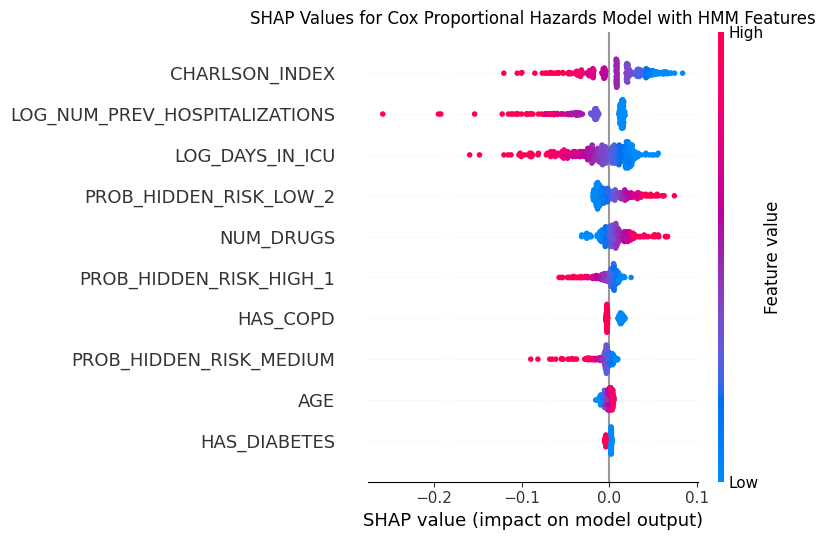

In [ ]:
import shap
from recurrent_health_events_prediction.model.explainers import explain_survival_model_prob

shap_values, _ = explain_survival_model_prob(next_event_model_cph_model_hmm_cov, X_train_scaled[final_features].head(10), X_test_scaled[final_features], t=30)

if shap_values.ndim == 3:  # (n_samples, n_features, n_classes)
    shap_values_to_plot = shap_values[:, :, 1]  # class 1
else:
    shap_values_to_plot = shap_values  # already (n_samples, n_features)

plt.title("SHAP Values for Cox Proportional Hazards Model with HMM Features")
shap.summary_plot(shap_values_to_plot, X_test_scaled[final_features].astype(float), 
                  feature_names=final_features)
plt.show()

#### CoxPH Model with Hidden State as Stratifier

In [ ]:
# Initialize the model with the configuration
from recurrent_health_events_prediction.model.NextEventPredictionModel import NextEventPredictionModel
from recurrent_health_events_prediction.model.model_types import SurvivalModelType

cph_hmm_strata_config = next_event_model_config['hmm_based'].copy()
cph_hmm_strata_config['features'] = final_features
cph_hmm_strata_config['model_name'] = "Cox Proportional Hazard Model with HMM Strata"
cph_hmm_strata_config['model_type'] = SurvivalModelType.COX_PH.value
cph_hmm_strata_config['cluster_col'] = None  # No clustering for this model
cph_hmm_strata_config['strata_col'] = 'HEALTH_HIDDEN_RISK'  # No strata for this model
cph_hmm_strata_config['base_hmm_name'] = hmm_model_name

In [ ]:
from recurrent_health_events_prediction.training.utils import train_next_event_survival_model_rand_search_cv

random_search_cph_strata_hmm = train_next_event_survival_model_rand_search_cv(
    training_df=X_train_scaled,
    model_config=cph_hmm_strata_config,
    strata_col_s=strata_col,
    param_grid=param_lifelines_grid,
    n_iter=n_iter,
    random_state=random_state,
    cv=cv
)

cph_model_strata_hmm = random_search_cph_strata_hmm.best_estimator_
cph_model_strata_hmm

NextEventSurvivalWrapper(columns_order=['AGE', 'CHARLSON_INDEX',
                                        'LOG_NUM_PREV_HOSPITALIZATIONS',
                                        'LOG_DAYS_IN_ICU', 'NUM_DRUGS',
                                        'HAS_DIABETES', 'HAS_COPD',
                                        'PROB_HIDDEN_RISK_HIGH_1',
                                        'PROB_HIDDEN_RISK_MEDIUM',
                                        'PROB_HIDDEN_RISK_LOW_2',
                                        'EVENT_DURATION', 'READMISSION_EVENT',
                                        'HEALTH_HIDDEN_RISK'],
                         model_config={'base_hmm_name': 'hmm_multiple_emissions_time_bina...
                                       'model_params': {'l1_ratio': np.float64(0.06210526315789474),
                                                        'penalizer': np.float64(0.07157894736842106)},
                                       'model_type': 'cox_ph',
                                       'save_model_path': '/workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm_survival_based',
                                       'strata_col': 'HEALTH_HIDDEN_RISK'},
                         model_params={'l1_ratio': np.float64(0.06210526315789474),
                                       'penalizer': np.float64(0.07157894736842106)})

In [ ]:
search_results_cph_strata_hmm = summarize_search_results(random_search_cph_strata_hmm)

10 candidates of Model trained and validated with cross-validation on 5 folds.
Best parameters: {'model_params': {'penalizer': np.float64(0.07157894736842106), 'l1_ratio': np.float64(0.06210526315789474)}}
Validation Score - Model: 0.606 ± 0.017


model,lifelines.CoxPHFitter
duration col,'EVENT_DURATION'
event col,'READMISSION_EVENT'
penalizer,0.071579
l1 ratio,0.062105
strata,HEALTH_HIDDEN_RISK
baseline estimation,breslow
number of observations,1352
number of events observed,642
partial log-likelihood,-3424.10
time fit was run,2025-07-14 19:20:49 UTC


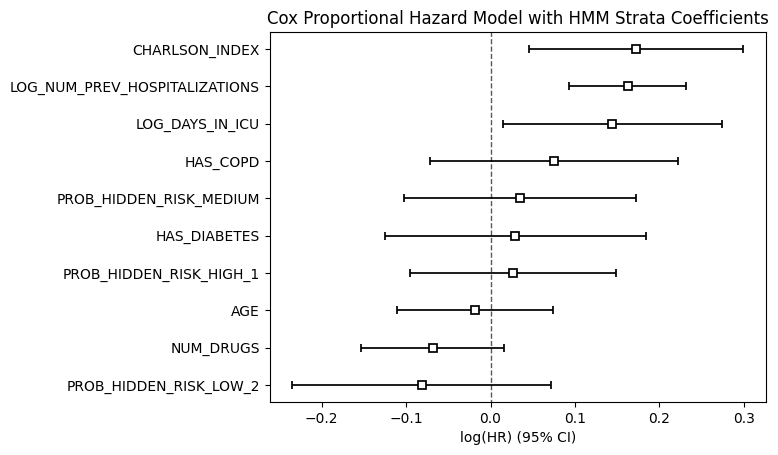

In [ ]:
next_event_model_cph_strata_hmm: NextEventPredictionModel = cph_model_strata_hmm.model
next_event_model_cph_strata_hmm.random_search_cv_results = search_results_cph_hmm_cov
next_event_model_cph_strata_hmm.model.print_summary()
ax = next_event_model_cph_strata_hmm.model.plot()
save_coef_lifelines_plot(ax, next_event_model_cph_strata_hmm)

In [ ]:
next_event_model_cph_strata_hmm.model.check_assumptions(X_train_scaled[final_features + ['EVENT_DURATION', 'READMISSION_EVENT', 'HEALTH_HIDDEN_RISK']], p_value_threshold=0.05)

Proportional hazard assumption looks okay.


[]

In [ ]:
next_event_model_cph_strata_hmm.plot_survival_function(X_train_scaled.iloc[:5], duration_col='EVENT_DURATION', n=3, event_col='READMISSION_EVENT')

In [ ]:
next_event_model_cph_strata_hmm.plot_survival_function(X_test_scaled.iloc[:-4], duration_col='EVENT_DURATION', n=3, event_col='READMISSION_EVENT')

##### Evaluation Train Dataset

In [ ]:
c_index_cox_ph = next_event_model_cph_strata_hmm.evaluate_c_index(X_train_scaled, save_metric=True, evaluation_set="train")
print(f"Train C-index for Cox Proportional Hazards Model: {c_index_cox_ph:.4f}")

Train C-index for Cox Proportional Hazards Model: 0.6141


In [ ]:
import matplotlib.pyplot as plt

from recurrent_health_events_prediction.training.utils import evaluate_model_around_specific_time

# Predict survival probabilities for a specific time point
time_point = 30  # Example time point
predicted_probs_df, auc = evaluate_model_around_specific_time(next_event_model_cph_strata_hmm, X_train_scaled, time_point, evaluation_set='train')


In [ ]:
next_event_model_cph_strata_hmm.model.baseline_survival_function_

##### Evaluation Test Dataset

In [ ]:
next_event_model_cph_strata_hmm.evaluate_c_index(X_test_scaled, save_metric=True, evaluation_set='test')

0.562833670558982

In [ ]:
from recurrent_health_events_prediction.training.utils import evaluate_model

# Evaluate the model on the test set
evaluate_model(
    next_event_model_cph_strata_hmm,
    X_train_scaled,
    X_test_scaled,
    save_plots=True,
    evaluation_times=evaluation_times,
    evaluation_set='test',
)

Test C-index for Cox Proportional Hazard Model with HMM Strata: 0.5628


Mean AUC-ROC for Cox Proportional Hazard Model with HMM Strata: 0.4921


In [ ]:
from recurrent_health_events_prediction.training.utils import evaluate_model_around_specific_time

prob_df, auc_roc = evaluate_model_around_specific_time(
    next_event_model_cph_strata_hmm,
    X_test_scaled,
    evaluation_time=30,
    save_plots=True,
    evaluation_set='test'
)

## Final Results

In [ ]:
models = [next_event_model_cph_model_hmm_cov, next_event_model_cph_strata_hmm]
for model in models:
    model.save_model()
    if model.random_search_cv_results is not None:
        model.save_random_search_cv_results()
    model.save_key_performance_metrics()
    model.save_model_params()

summary_results = {
    "Model": [],
    "Features": [],
    "C-Index": [],
    "Avg. Brier Score": [],
    "AUC 30 Days": [],
    "Avg. Time-Dependent AUC": []
}

for model in models:
    summary_results["Model"].append(model.model_name)
    summary_results["Features"].append(", ".join(model.feature_names_in_))
    summary_results["C-Index"].append(model.key_test_performance_metrics['c_index'])
    summary_results["Avg. Brier Score"].append(model.key_test_performance_metrics['avg_brier_score'])
    summary_results["AUC 30 Days"].append(model.key_test_performance_metrics.get('auc_roc_at_t_30', 0.5))
    summary_results["Avg. Time-Dependent AUC"].append(model.key_test_performance_metrics['avg_cumulative_dynamic_auc'])

summary_df = pd.DataFrame(summary_results)
summary_df = summary_df.sort_values(by="C-Index", ascending=False)
summary_df.reset_index(drop=True, inplace=True)
summary_df

Saving model to /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm_survival_based/cox_proportional_hazard_model_with_hmm_features/cox_proportional_hazard_model_with_hmm_features.pkl
Saving model to /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm_survival_based/cox_proportional_hazard_model_with_hmm_strata/cox_proportional_hazard_model_with_hmm_strata.pkl


,Model,Features,C-Index,Avg. Brier Score,AUC 30 Days,Avg. Time-Dependent AUC
0,Cox Proportional Hazard Model with HMM Features,"AGE, CHARLSON_INDEX, LOG_NUM_PREV_HOSPITALIZAT...",0.565052,0.194754,0.577642,0.594956
1,Cox Proportional Hazard Model with HMM Strata,"AGE, CHARLSON_INDEX, LOG_NUM_PREV_HOSPITALIZAT...",0.562834,0.210638,0.486892,0.492143
